In [94]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import warnings
warnings.filterwarnings('ignore')

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import  DecisionTreeClassifier

plt.style.use('fivethirtyeight')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Exploratory Data Analysis

In [95]:
data_train = pd.read_csv('kaggle/input/av-genpact-hack-dec2018/train.csv')
data_test = pd.read_csv('kaggle/input/av-genpact-hack-dec2018/test.csv')
data_meal = pd.read_csv('kaggle/input/av-genpact-hack-dec2018/meal_info.csv')
data_center = pd.read_csv('kaggle/input/av-genpact-hack-dec2018/fulfilment_center_info.csv')

data_train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


### Merge DataFrames

In [96]:
data_train = data_train.merge(data_meal)
data_train = data_train.merge(data_center)
data_train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0
1,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,56,TYPE_C,2.0
2,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,56,TYPE_C,2.0
3,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,56,TYPE_C,2.0
4,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,56,TYPE_C,2.0


### Num orders categorize

In [97]:
data_train['num_orders'].quantile([.33, .67, .9])

0.33     69.0
0.67    244.0
0.90    609.0
Name: num_orders, dtype: float64

In [98]:
def no_cat(num):
    if num < 136.0:
        return 'Low'
    elif num < 324.0:
        return 'Medium'
    elif num < 609.0:
        return 'High'
    else:
        return 'Very High'
    
data_train['num_orders_cat'] = data_train['num_orders'].apply(no_cat)
data_train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,category,cuisine,city_code,region_code,center_type,op_area,num_orders_cat
0,1379560,1,55,1885,136.83,152.29,0,0,177,Beverages,Thai,647,56,TYPE_C,2.0,Medium
1,1018704,2,55,1885,135.83,152.29,0,0,323,Beverages,Thai,647,56,TYPE_C,2.0,Medium
2,1196273,3,55,1885,132.92,133.92,0,0,96,Beverages,Thai,647,56,TYPE_C,2.0,Low
3,1116527,4,55,1885,135.86,134.86,0,0,163,Beverages,Thai,647,56,TYPE_C,2.0,Medium
4,1343872,5,55,1885,146.50,147.50,0,0,215,Beverages,Thai,647,56,TYPE_C,2.0,Medium


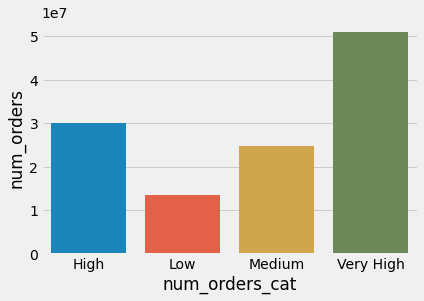

In [99]:
data = data_train.groupby(['num_orders_cat'])['num_orders'].sum().reset_index()
sns.barplot(x='num_orders_cat', y='num_orders', data=data)

### Num Orders - Category

In [100]:
data = data_train.groupby(['category'])['num_orders'].sum().reset_index()
data

,category,num_orders
0,Beverages,40480525
1,Biryani,631848
2,Desert,1940754
3,Extras,3984979
4,Fish,871959
5,Other Snacks,4766293
6,Pasta,1637744
7,Pizza,7383720
8,Rice Bowl,20874063
9,Salad,10944336


In [101]:
data['num_orders'].quantile([.33, .67])

0.33    2165492.40
0.67    6624666.17
Name: num_orders, dtype: float64

In [102]:
def no_cat_cat(no):
    if no < 2165492.40:
        return 'Low'
    elif no < 6624666.17:
        return 'Medium'
    else:
        return 'High'

data['num_orders_cat'] = data['num_orders'].apply(no_cat_cat)
data.sort_values(by='num_orders', ascending=False)

,category,num_orders,num_orders_cat
0,Beverages,40480525,High
8,Rice Bowl,20874063,High
10,Sandwich,17636782,High
9,Salad,10944336,High
7,Pizza,7383720,High
5,Other Snacks,4766293,Medium
13,Starters,4649122,Medium
3,Extras,3984979,Medium
11,Seafood,2715714,Medium
2,Desert,1940754,Low


### Num Orders - Week

In [103]:
data = data_train.groupby(['week'])['num_orders'].sum().reset_index()
data

,week,num_orders
0,1,792261
1,2,787084
2,3,695262
3,4,743529
4,5,1198675
...,...,...
140,141,776240
141,142,739661
142,143,759926
143,144,801197


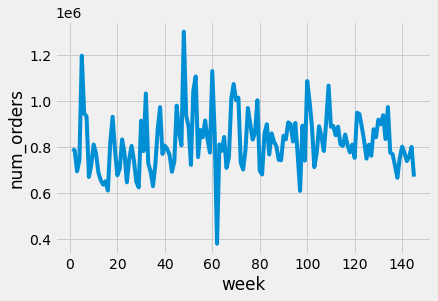

In [104]:
sns.lineplot(x='week', y='num_orders', data=data)

### Num Orders - Fulfilment Center per Region

In [105]:
data = data_train.groupby(['region_code'])['num_orders'].sum().reset_index()
data.head()

,region_code,num_orders
0,23,1609906
1,34,24051733
2,35,691044
3,56,60520191
4,71,2103282


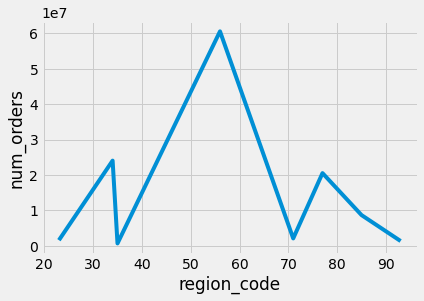

In [106]:
sns.lineplot(x='region_code', y='num_orders', data=data)

### Fulfilment center data

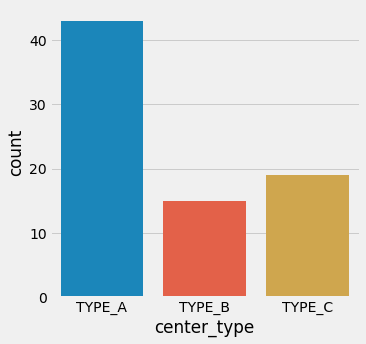

In [107]:
sns.factorplot(x='center_type', kind='count', data=data_center)

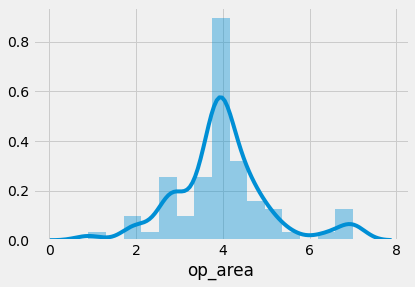

In [108]:
sns.distplot(data_center.op_area)

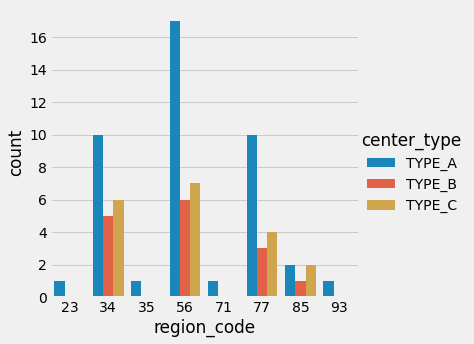

In [109]:
sns.factorplot(x='region_code', kind='count', hue='center_type', data=data_center)

### Jumlah per Featured on main page

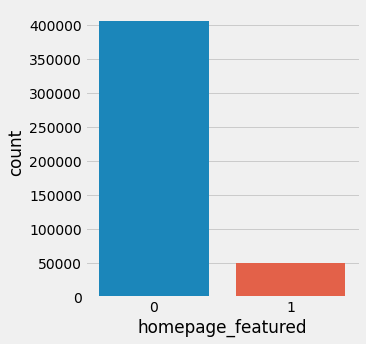

In [110]:
sns.factorplot(x='homepage_featured', kind='count', data=data_train)

In [111]:
sns

<module 'seaborn' from 'E:\\Anaconda_Python\\lib\\site-packages\\seaborn\\__init__.py'>

### Jumlah per Email promotion

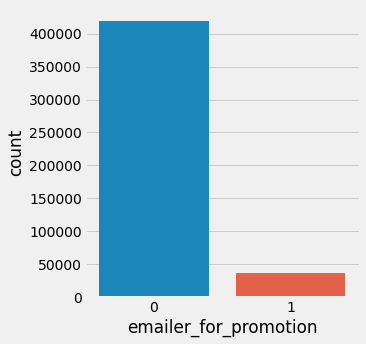

In [112]:
sns.factorplot(x='emailer_for_promotion', kind='count', data=data_train)

# Preprocessing

In [113]:
data_train = pd.read_csv('kaggle/input/av-genpact-hack-dec2018/train.csv')
data_test = pd.read_csv('kaggle/input/av-genpact-hack-dec2018/test.csv')

data_train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders
0,1379560,1,55,1885,136.83,152.29,0,0,177
1,1466964,1,55,1993,136.83,135.83,0,0,270
2,1346989,1,55,2539,134.86,135.86,0,0,189
3,1338232,1,55,2139,339.50,437.53,0,0,54
4,1448490,1,55,2631,243.50,242.50,0,0,40


In [114]:
data_test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


# Prediction

In [115]:
X_train = data_train.drop('num_orders', axis=1).fillna(0)
y_train = data_train['num_orders']
X_test = data_test.copy()
X_train.shape, y_train.shape, X_test.shape

((456548, 8), (456548,), (32573, 8))

### Logistic Regression

In [ ]:
random_forest = RandomForestRegressor(n_estimators = 300, random_state= 0)
random_forest.fit(X_train, y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest